In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from collections import Counter

In [2]:
# Transformations: convert images to tensors
transform = transforms.ToTensor()

# Load training and test datasets
train_dataset = torchvision.datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root="./data", train=False, transform=transform, download=True)

# Create DataLoaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# Check dataset size
print(f"Training dataset size: {len(train_dataset)} images")
print(f"Test dataset size: {len(test_dataset)} images")

Training dataset size: 60000 images
Test dataset size: 10000 images


64


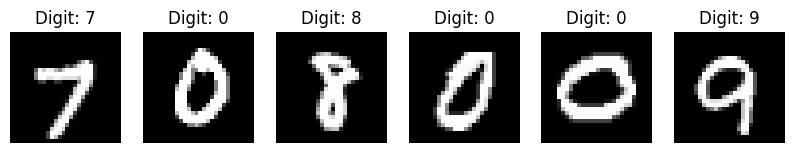

In [3]:
# Get the first batch of data
images, labels = next(iter(train_loader))
print(labels.size(0))
# Display the first 6 images
fig, axes = plt.subplots(1, 6, figsize=(10, 3))
for i in range(6):
    axes[i].imshow(images[i].squeeze(), cmap="gray")
    axes[i].set_title(f"Digit: {labels[i].item()}")
    axes[i].axis("off")
plt.show()

Text(0, 0.5, 'Number of samples')

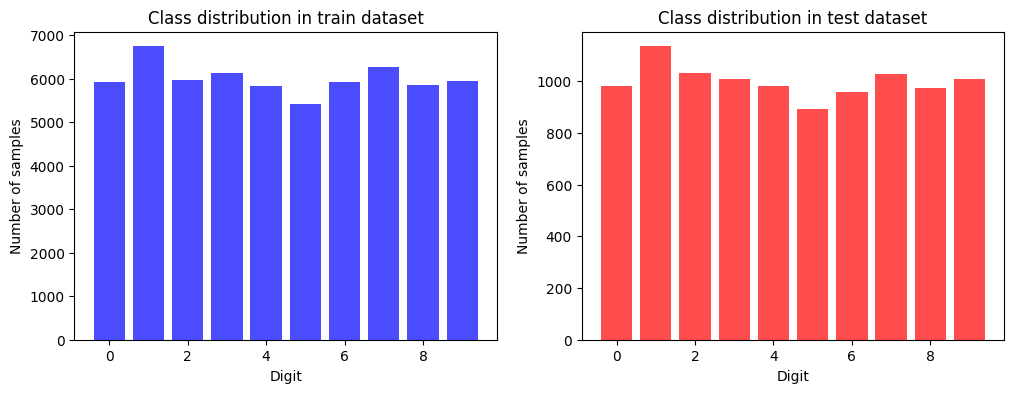

In [4]:
# Analyze class distribution
train_labels = [label for _, label in train_dataset]
test_labels = [label for _, label in test_dataset]

train_counts = Counter(train_labels)
test_counts = Counter(test_labels)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].bar(train_counts.keys(), train_counts.values(), color="blue", alpha=0.7)
axes[0].set_title("Class distribution in train dataset")
axes[0].set_xlabel("Digit")
axes[0].set_ylabel("Number of samples")

axes[1].bar(test_counts.keys(), test_counts.values(), color="red", alpha=0.7)
axes[1].set_title("Class distribution in test dataset")
axes[1].set_xlabel("Digit")
axes[1].set_ylabel("Number of samples")

In [5]:
class Naive_Bayes_Classifier:
    def __init__(self, num_classes=10):
        self.num_classes = num_classes
        self.class_priors = None
        self.pixel_likelihoods = None
    
    def fit(self, train_loader):
        """
        Trains a classifier by estimating prior class probabilities and class-conditional probabilities of pixels.
        """
        class_counts = torch.zeros(self.num_classes)
        pixel_counts = torch.zeros(self.num_classes, 28, 28)
        
        for images, labels in train_loader:
            for image, label in zip(images, labels):
                class_counts[label] += 1
                pixel_counts[label] += image.squeeze()
        
        self.class_priors = class_counts / class_counts.sum()
        self.pixel_likelihoods = (pixel_counts + 1) / (class_counts.view(-1, 1, 1) + 2)
        return self
    
    def predict(self, images):
        log_priors = torch.log(self.class_priors)
        log_likelihoods = torch.log(self.pixel_likelihoods)
        
        batch_size = images.shape[0]
        images = images.view(batch_size, 28, 28)
        
        log_probs = log_priors.view(1, -1) + (images.unsqueeze(1) * log_likelihoods).sum(dim=(2, 3))
        
        return torch.argmax(log_probs, dim=1)


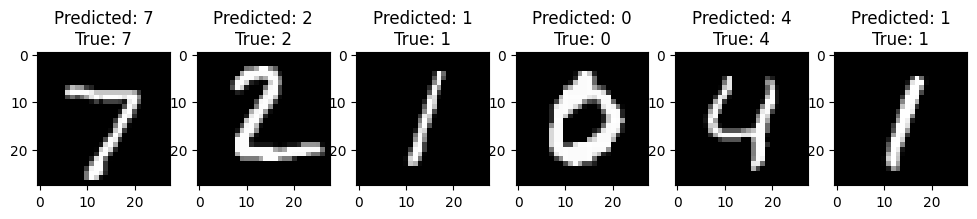

In [6]:
test_images, test_labels = next(iter(test_loader))

model = Naive_Bayes_Classifier()
model.fit(train_loader)

predictions = model.predict(test_images)

fig, axes = plt.subplots(1, 6, figsize=(12,3))

for i in range(6):
    axes[i].imshow(test_images[i].squeeze(), cmap='gray')
    axes[i].set_title(f"Predicted: {predictions[i]}\nTrue: {test_labels[i].item()}")
    #axes[i].axis("off")

plt.show()    

In [7]:
def evaluate(model, data_loader: torch.utils.data.DataLoader) -> float:
    correct = 0
    total = 0

    for images, labels in data_loader:
        predictions = model.predict(images)
        correct += (predictions == labels.numpy()).sum()
        total += labels.size(0)
        
    return float(correct/total)

In [8]:
test_accuracy = evaluate(model, test_loader)
print(f"Accuracy on test dataset: {test_accuracy:.4f}")

Accuracy on test dataset: 0.6903
